# **Detect Moving Objects**

In this notebook, we will detect moving objects from a drone video

In [1]:
import os
from glob import glob
import re
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Get video sequence from Virat Video Dataset

In [2]:
fpath = r"C:\Users\itber\Documents\datasets\VisDrone\VisDrone2019-VID-train\sequences\uav0000352_05980_v"

image_paths = sorted(glob(f"{fpath}/*.jpg"), key=lambda x:float(re.findall("(\d+)",x)[0]))
len(image_paths)

196

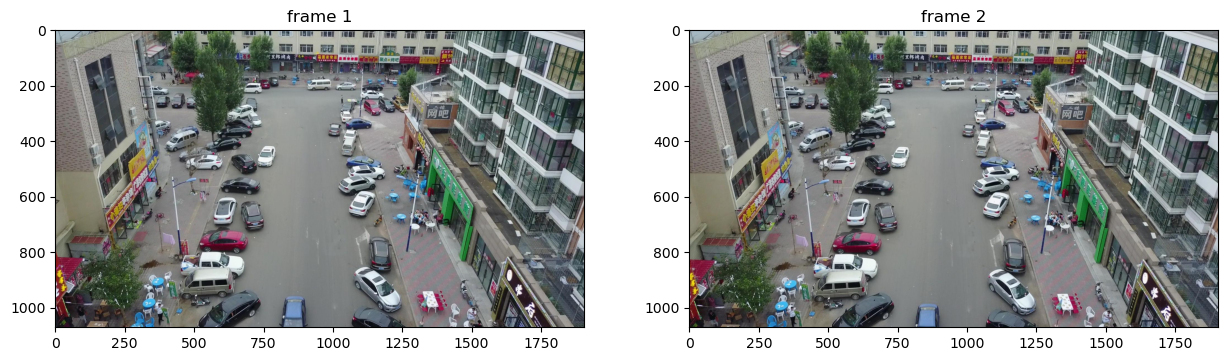

In [3]:
idx = 9
frame1 = cv2.cvtColor(cv2.imread(image_paths[idx]), cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(cv2.imread(image_paths[idx + 1]), cv2.COLOR_BGR2RGB)
frame3 = cv2.cvtColor(cv2.imread(image_paths[idx + 2]), cv2.COLOR_BGR2RGB)
frame4 = cv2.cvtColor(cv2.imread(image_paths[idx + 3]), cv2.COLOR_BGR2RGB)

_, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(frame1)
ax[0].set_title("frame 1")
ax[1].imshow(frame2)
ax[1].set_title("frame 2");

# **Camera Motion Compensation**

Now we will implement camera motion compensation to get a better flow estimate with a moving ego camera

In [72]:
def motion_comp(prev_frame, curr_frame, num_points=500, points_to_use=500, transform_type='affine'):
    """ Obtains new warped frame1 to account for camera (ego) motion
        Inputs:
            prev_frame - first image frame
            curr_frame - second sequential image frame
            num_points - number of feature points to obtain from the images
            points_to_use - number of point to use for motion translation estimation 
            transform_type - type of transform to use: either 'affine' or 'homography'
        Outputs:
            A - estimated motion translation matrix or homography matrix
            prev_points - feature points obtained on previous image
            curr_points - feature points obtaine on current image
        """
    transform_type = transform_type.lower()
    assert(transform_type in ['affine', 'homography'])

    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_RGB2GRAY)
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_RGB2GRAY)

    # get features for first frame
    corners = cv2.goodFeaturesToTrack(prev_gray, num_points, qualityLevel=0.01, minDistance=10)

    # get matching features in next frame with Sparse Optical Flow Estimation
    matched_corners, status, _ = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, corners, None)

    # reformat previous and current corner points
    prev_points = corners[status==1]
    curr_points = matched_corners[status==1]

    # sub sample number of points so we don't overfit
    if points_to_use > prev_points.shape[0]:
        points_to_use = prev_points.shape[0]

    index = np.random.choice(prev_points.shape[0], size=points_to_use, replace=False)
    prev_points_used = prev_points[index]
    curr_points_used = curr_points[index]

    # find transformation matrix from frame 1 to frame 2
    if transform_type == 'affine':
        # A0, _ = cv2.estimateAffinePartial2D(prev_points_used, curr_points_used, method=cv2.RANSAC)
        A, _ = cv2.estimateAffine2D(prev_points_used, curr_points_used, method=cv2.RANSAC)
    elif transform_type == 'homography':
        A, _ = cv2.findHomography(prev_points_used, curr_points_used)

    # TEMP
    # print(A0)
    # print(A)
    # print(H)

    return A, prev_points, curr_points

Get warped/transformed frame 1

In [35]:
def get_color(number):
    """ Converts an integer number to a color """
    # change these however you want to
    blue = int(number*30 % 256)
    green = int(number*103 % 256)
    red = int(number*50 % 256)

    return red, blue, green


def plot_points(image, points, radius=3, color=(0,255,0)):
    for x,y in points:
        cv2.circle(image, (int(x), int(y)), radius, color, thickness=-1)

    return image

In [37]:
A, prev_points, curr_points = motion_comp(frame1, frame2, num_points=10000, points_to_use=10000, transform_type='homography')

In [39]:
# warp frame 1 to account for camera motion
# transformed1 = cv2.warpAffine(frame1, A, dsize=(frame1.shape[:2][::-1])) # affine transform
transformed1 = cv2.warpPerspective(frame1, A, dsize=(frame1.shape[:2][::-1])) # homography transform

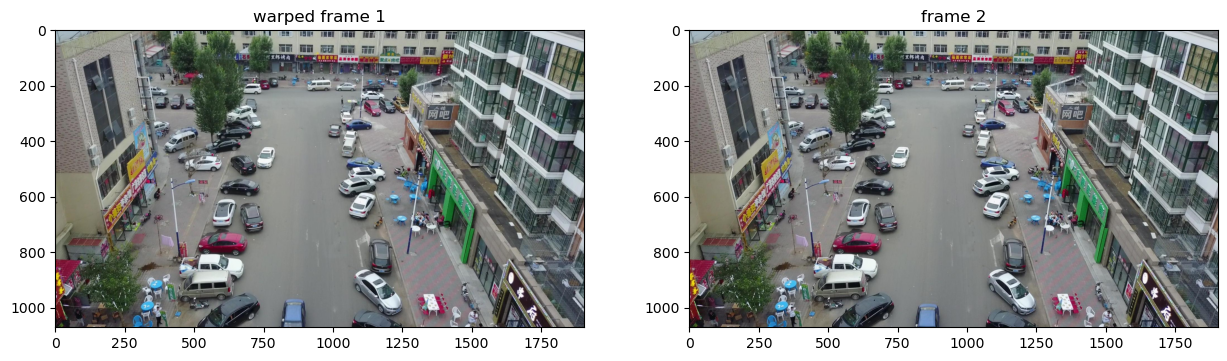

In [40]:
_, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(transformed1)
ax[0].set_title("warped frame 1")
ax[1].imshow(frame2)
ax[1].set_title("frame 2");

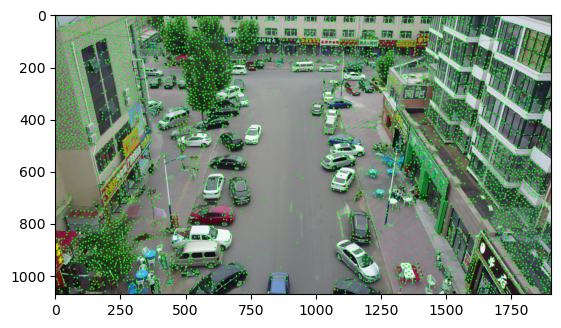

In [41]:
img = plot_points(frame2.copy(), curr_points)

plt.imshow(img)

In [42]:
prev_points[0], curr_points[0]

(array([170., 915.], dtype=float32),
 array([162.42023, 925.606  ], dtype=float32))

#### Use the Affine Transformation matrix to transform the previous points and account for the ego motion

In [51]:
# warped_points = prev_points @ A # affine
warped_points = np.hstack((prev_points, np.ones((len(prev_points), 1)))) @ A # homography
warped_points = warped_points[:, :2]

In [52]:
curr_points.max(axis=0)

array([1912.8325, 1079.7168], dtype=float32)

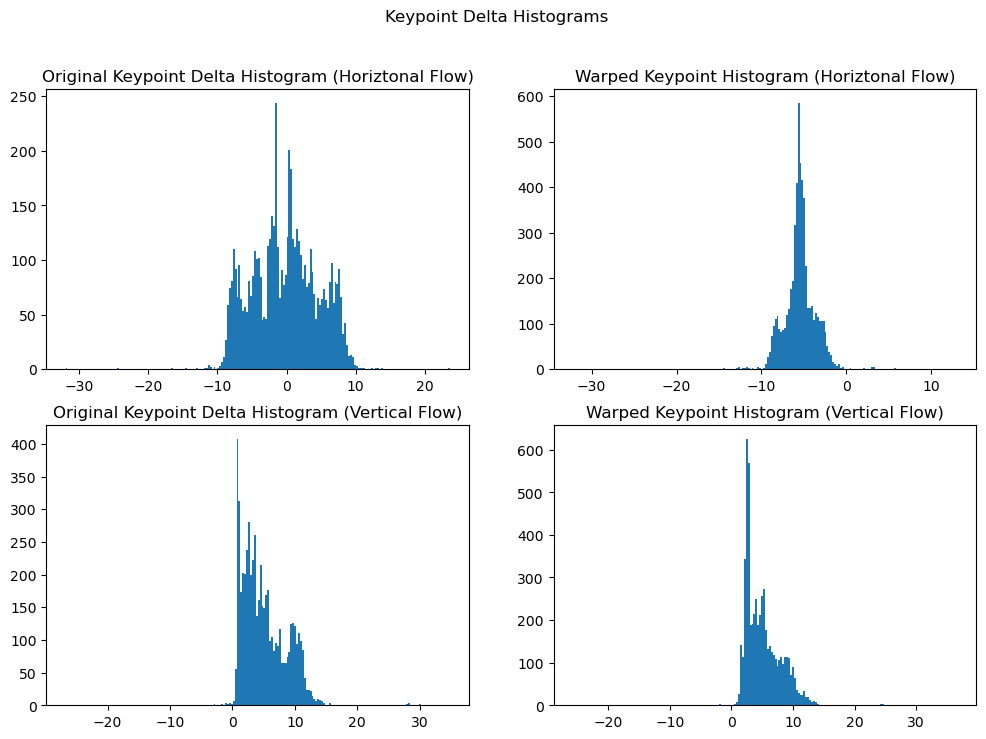

In [53]:
num_bins = 200
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Keypoint Delta Histograms")
ax[0][0].hist(curr_points[:, 0] - prev_points[:, 0], bins=num_bins);
ax[0][0].set_title("Original Keypoint Delta Histogram (Horiztonal Flow)")
ax[0][1].hist(curr_points[:, 0] - warped_points[:, 0], bins=num_bins);
ax[0][1].set_title("Warped Keypoint Histogram (Horiztonal Flow)");

ax[1][0].hist(curr_points[:, 1] - prev_points[:, 1], bins=num_bins);
ax[1][0].set_title("Original Keypoint Delta Histogram (Vertical Flow)")
ax[1][1].hist(curr_points[:, 1] - warped_points[:, 1], bins=num_bins);
ax[1][1].set_title("Warped Keypoint Histogram (Vertical Flow)");

In [54]:
c = 2 # tunable scale factor
comp = 500
# x = np.sum(np.abs(curr_points - warped_points), axis=1) # l1 norm
x = np.linalg.norm(curr_points - warped_points, ord=2, axis=1) # l2 norm

# # apply position compensation for pixels closer to camera (typically on bottom of the frame)
# comp_index = curr_points[:, 1] > comp
# x = x + x.mean() - x[comp_index].mean()

mu = np.mean(x)
sig = np.std(x)

# upper and lower bounds for outlier detection
upper_bound = mu + c*sig
lower_bound = mu - c*sig

# display statistics
mu, sig, upper_bound, lower_bound

(7.967846981395888, 2.1037584067636534, 12.175363794923195, 3.760330167868581)

Get index for motion points

In [55]:
# idx = (x >= lower_bound) & (x >= upper_bound)
idx = (x <= lower_bound) | (x >= upper_bound)
idx.sum()

131

Possibly use the Kurtosis to help determine the optimal threshold, may need to train a lienar model for this

In [56]:
from scipy.stats import kurtosis

kurtosis(x)

32.4843221597135

Need to find a way to get the optimal threshold. Possible shoose several thresholds and stop when an optimal number of points is reached. i.e. if we get 2000 motion points, then we need to increase the threshold. Need to find a more statistically sound method that will adapt to different changin conditions.

### Display Motion Points

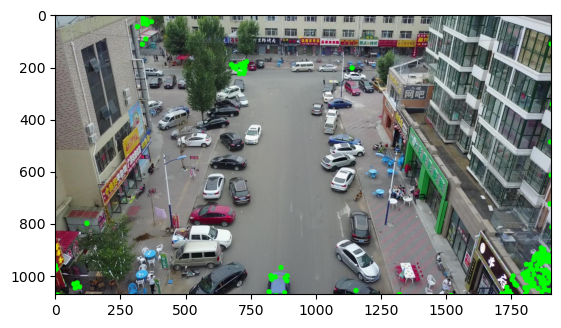

In [57]:
motion_points = curr_points[idx]
img = plot_points(frame2.copy(), motion_points, radius=10)

plt.imshow(img)

Possible use other features to perform clustering

- Magnitude?
- Angle?

In [58]:
magnitude = np.linalg.norm(motion_points, ord=2, axis=1)
angle = np.arctan2(motion_points[:, 0], motion_points[:, 1]) # horizontal/vertial

X = np.hstack((motion_points, np.c_[magnitude], np.c_[angle]))
X.shape

(131, 4)

### Cluster the detected motion points

In [59]:
from sklearn.cluster import DBSCAN, HDBSCAN, OPTICS

clustering = DBSCAN(eps=50.0, min_samples=5) # DBSCAN is seems to work the best
# clustering = HDBSCAN(min_cluster_size=5, cluster_selection_epsilon=50.0)
# clustering = OPTICS(min_cluster_size=5, max_eps=50)

clustering.fit(motion_points)
# clustering.fit(X)

DBSCAN(eps=50.0)

In [60]:
np.unique(clustering.labels_)

array([-1,  0,  1,  2,  3], dtype=int64)

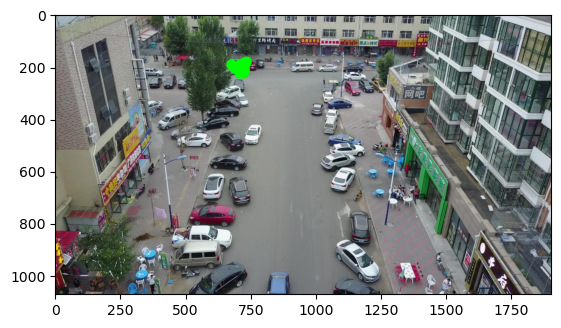

In [61]:
lbl = 0
img = plot_points(frame2.copy(), motion_points[clustering.labels_ == lbl], radius=20)

plt.imshow(img)

### Remove clusters with non-uniform direction

Clusters of real objects should have uniform direction, so we will filter the clusters based on standard deviation of detected flow vectors.

In [62]:
delta = warped_points[idx][clustering.labels_ == lbl] - curr_points[idx][clustering.labels_ == lbl]

print(np.degrees(np.arctan2(delta[:,0], delta[:,1])).std())
print(np.arctan2(delta[:,0], delta[:,1]).std())

1.0465161867596202
0.018265153134371256


In [69]:
# set angle uniformity threshold
thresh = 0.1 # radians
cluster_labels = [] # clusters to keep
for lbl in np.unique(clustering.labels_):
    delta = warped_points[idx][clustering.labels_ == lbl] - curr_points[idx][clustering.labels_ == lbl]
    angle_std = np.arctan2(delta[:,0], delta[:,1]).std()
    if angle_std <= thresh:
        cluster_labels.append(lbl)

    # TEMP
    # print(np.degrees(np.arctan2(delta[:,0], delta[:,1])).std())
    # print(np.arctan2(delta[:,0], delta[:,1]).std())
    # print()

cluster_labels

[0, 2, 3]

## Draw Detected Clusters

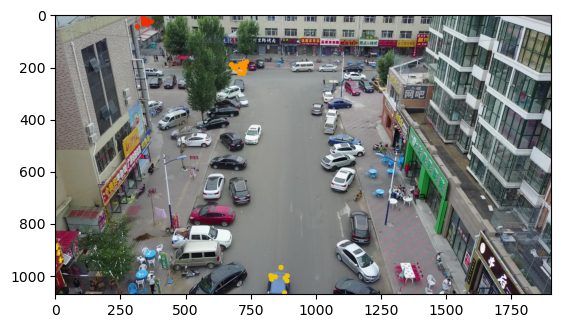

In [70]:
img = frame2.copy()
clusters = []
for i, lbl in enumerate(cluster_labels):
    cluster = motion_points[clustering.labels_ == lbl]
    clusters.append(cluster)
    
    color = get_color((i+1)*5)
    img = plot_points(img, cluster, radius=10, color=color)

plt.imshow(img)

## Make Pipeline
1. Get Affine Transformation matrix for motion compensation between frames
2. Use transformation matrix to transform previous image and key points
3. Get distance metric between current and previous keypoints
4. Get outlier bounds
5. Get motion points
6. Cluster Motion Points
7. Filter clusters with large variation in angular motion

In [71]:
def get_outlier_bounds(x, c=2):
    """ Obtains outlier bounds for a given keypoint distance metric 
        (distance from warped frame 1 to frame2)
        Inputs:
            x - distance metric between current and previous keypoints
            c - tunable scale factor
        Outputs:
            upper_bound - upper bound for inliers (anything greater is an outlier)
            lower_bound - lower bound for inliers (anything lesser is an outlier)
        """
    mu = np.mean(x)
    sig = np.std(x)

    # upper and lower bounds for outlier detection
    upper_bound = mu + c*sig
    lower_bound = mu - c*sig

    return upper_bound, lower_bound

In [75]:
from scipy.stats import kurtosis


def get_motion_detections(frame1, frame2, cluster_model, c=2, angle_thresh=0.1, distance_metric='l2', transform_type='affine'):
    """ Obtains detected motion betweej frame 1 and frame 2 
        Inputs:
            frame1 - previous frame
            frame2 - current frame
            cluster_model - cluster model object
            c - tunable hyperparamer fo outlier detection
            angle_thresh - threshold for angular uniformity of the cluster 
                (Determeins if the Std Dev of the Cluster flow angles is too large)
            distance_metric - used to compute the distance between current and previous keypoints
            transform_type - type of transform to use: either 'affine' or 'homography'
        Outputs:
            clusters - list containing clusters of detected motion keypoints
        """

    # get affine transformation matrix for motion compensation between frames
    A, prev_points, curr_points = motion_comp(frame1, frame2, num_points=10000, points_to_use=5000, transform_type=transform_type)

    # Use transformation matrix to transform previous image and key points
    # transformed1 = cv2.warpAffine(frame1, A, dsize=(frame1.shape[:2][::-1]))

    # get transformed key points
    if transform_type == 'affine':
        warped_points = prev_points @ A
    elif transform_type == 'homography': 
        warped_points = np.hstack((prev_points, np.ones((len(prev_points), 1)))) @ A

    warped_points = warped_points[:, :2]

    # get a distance metric for the current and previous keypoints
    if distance_metric == 'l1':
        x = np.sum(np.abs(curr_points - warped_points), axis=1) # l1 norm
    else:
        x = np.linalg.norm(curr_points - warped_points, ord=2, axis=1) # l2 norm
    
    # # compute kurtosis of x to determine outlier hyperparameter c
    k = kurtosis(x)

    # probably need to train some model for this
    if k < 1:
        c /= 2 # reduce outlier hyparameter

    # get outlier bounds
    upper_bound, lower_bound = get_outlier_bounds(x, c)

    # get motion points
    motion_idx = (x <= lower_bound) | (x >= upper_bound)
    motion_points = curr_points[motion_idx]

    # cluster motion points
    cluster_model.fit(motion_points)

    # filter clusters with large variation in angular motion
    clusters = []
    for lbl in np.unique(cluster_model.labels_):
        delta = warped_points[motion_idx][cluster_model.labels_ == lbl] - motion_points[cluster_model.labels_ == lbl]
        angle_std = np.arctan2(delta[:,0], delta[:,1]).std()
        if angle_std <= angle_thresh:
            cluster_labels.append(lbl)
            clusters.append(motion_points[cluster_model.labels_ == lbl])
    
    return clusters


In [76]:
cluster_model = DBSCAN(eps=50.0, min_samples=5) # DBSCAN is seems to work the best

In [82]:
%timeit clusters = get_motion_detections(frame1, frame2, cluster_model, angle_thresh=0.1, distance_metric='l2', transform_type='affine')

61.1 ms ± 1.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Iterate through all frames

In [83]:
cluster_model = DBSCAN(eps=50.0, min_samples=5) # DBSCAN is seems to work the best

frames = []
for i in range(len(image_paths) - 1):
    frame1 = cv2.imread(image_paths[i])
    frame2 = cv2.imread(image_paths[i + 1])

    # get detected cluster
    clusters = get_motion_detections(frame1, frame2, cluster_model, angle_thresh=0.1, distance_metric='l2', transform_type='homography')

    # draw detected clusters
    for j, cluster in enumerate(clusters):
        color = get_color((j+1)*5)
        frame2 = plot_points(frame2, cluster, radius=10, color=color)
    
    frames.append(frame2)

#### Make Video

In [ ]:
out = cv2.VideoWriter('drone_detection_sparse_homography.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 20, (1904, 1071))

for img in frames:
    out.write(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

out.release()

Run on another training video

In [395]:
fpath = r"C:\Users\itber\Documents\datasets\VisDrone\VisDrone2019-VID-train\sequences\uav0000366_00001_v"

image_paths = sorted(glob(f"{fpath}/*.jpg"), key=lambda x:float(re.findall("(\d+)",x)[0]))
len(image_paths)

296

In [396]:
cluster_model = DBSCAN(eps=50.0, min_samples=3) # DBSCAN is seems to work the best

frames = []
for i in range(len(image_paths) - 1):
    frame1 = cv2.imread(image_paths[i])
    frame2 = cv2.imread(image_paths[i + 1])

    # get detected cluster
    clusters = get_motion_detections(frame1, frame2, cluster_model, c=3, angle_thresh=0.1, distance_metric='l2')

    # draw detected clusters
    for j, cluster in enumerate(clusters):
        color = get_color((j+1)*5)
        frame2 = plot_points(frame2, cluster, radius=10, color=color)
    
    frames.append(frame2)

In [397]:
out = cv2.VideoWriter('drone_detection_sparse_366_4.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 20, (1904, 1071))

for img in frames:
    out.write(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

out.release()

## How about another video?

In [415]:
fpath = r"C:\Users\itber\Documents\datasets\VisDrone\VisDrone2019-VID-train\sequences\uav0000013_00000_v"
# fpath = r"C:\Users\itber\Documents\datasets\VisDrone\VisDrone2019-VID-train\sequences\uav0000013_01073_v"

image_paths = sorted(glob(f"{fpath}/*.jpg"), key=lambda x:float(re.findall("(\d+)",x)[0]))
len(image_paths)

269

In [416]:
cluster_model = DBSCAN(eps=50.0, min_samples=3) # DBSCAN is seems to work the best

frames = []
for i in range(len(image_paths) - 1):
    frame1 = cv2.imread(image_paths[i])
    frame2 = cv2.imread(image_paths[i + 1])

    # get detected cluster
    clusters = get_motion_detections(frame1, frame2, cluster_model, c=3, angle_thresh=0.1, distance_metric='l2')

    # draw detected clusters
    for j, cluster in enumerate(clusters):
        color = get_color((j+1)*5)
        frame2 = plot_points(frame2, cluster, radius=10, color=color)
    
    frames.append(frame2)

In [417]:
out = cv2.VideoWriter('drone_detection_sparse_013_2.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 20, (frames[0].shape[:2][::-1]))

for img in frames:
    out.write(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

out.release()
del out